# Hyperspectral Image Analysis - Classification

In [4]:
%%capture
!python -m pip install --upgrade git+git://github.com/abraia/abraia-multiple.git

import os
from dotenv import load_dotenv
load_dotenv()

if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

import numpy as np
import matplotlib.pyplot as plt

from multiple import *

multiple = Multiple()

## Download and read the HSI data

We use the Indian Pines(IP) Hyperspectral Image Dataset. The Indian Pines(IP) HSI data is gathered using the AVIRIS sensor over the Indian Pines test site in North-western Indiana and it consists of 145 X 145 pixels, 16 classes, and 200 bands. Here are the Ground Truth details of the Indian Pines(IP) Dataset:

![](https://miro.medium.com/max/775/1*XFC1rD8kpAxowJGuCch3ow.png)

*Ground Truth Details of Indian Pines(IP) Dataset*

In [7]:
%%capture
#@markdown <a href="https://abraia.me/console/gallery" target="_blank">Upload your hyperspectral data</a>
if not os.path.exists('Indian_pines_corrected.mat') or not os.path.exists('Indian_pines_gt.mat'):
    !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
    !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
multiple.upload('Indian_pines_corrected.mat')
multiple.upload('Indian_pines_gt.mat')

In [10]:
img = multiple.load_image('Indian_pines_corrected.mat')
gt = multiple.load_image('Indian_pines_gt.mat')

img.shape, gt.shape

((145, 145, 200), (145, 145))

## Visualize bands and ground truth

In [13]:
imgs, indexes = hsi.random(img)
ax = plt.subplots(2, 3)[1].reshape(-1)
for i, img in enumerate(imgs):
    #ax[i].title(f"Band - {i}")
    ax[i].imshow(img, cmap='nipy_spectral')
    ax[i].axis('off')

IndexError: tuple index out of range

In [ ]:
plt.imshow(gt, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

## Principal Component Analysis (PCA)


In [ ]:
from sklearn.decomposition import PCA

X, y = img, gt
r, c, d = X.shape
X = X.reshape((r * c), d)
y = y.reshape((r * c))

pca = PCA(n_components=85)
principalComponents = pca.fit_transform(X)
ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Select 40 as the no.of components for PCA

In [16]:
pca = PCA(n_components=40)
dt = pca.fit_transform(X)
dt = dt.reshape(r, c, 40)

fig = plt.figure(figsize=(16,8))
for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.title(f"Band - {i}")
    plt.imshow(dt[:,:,i], cmap='nipy_spectral')
    plt.axis('off')

NameError: name 'r' is not defined

## Support Vector Machine (SVM)


In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

class_names = ['', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture','Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
svm =  SVC(C=100, kernel='rbf', cache_size=10*1024)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

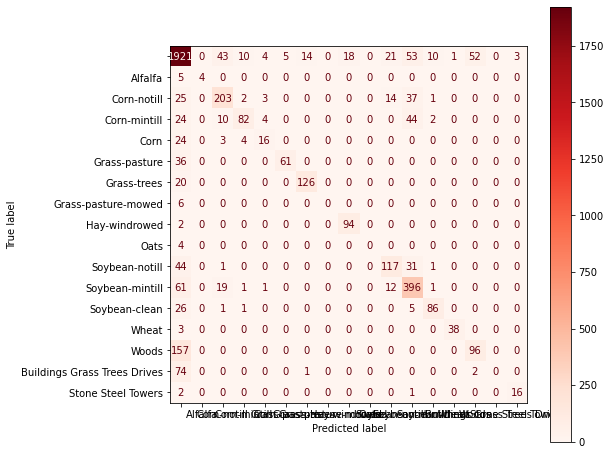

In [11]:
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
disp = plot_confusion_matrix(svm, X_test, y_test, display_labels=class_names, cmap=plt.cm.Reds, ax=plt.subplot())
disp.confusion_matrix
plt.show()

In [12]:
print(classification_report(y_test, y_pred, target_names=class_names))

                              precision    recall  f1-score   support

                                   0.79      0.89      0.84      2155
                     Alfalfa       1.00      0.44      0.62         9
                 Corn-notill       0.72      0.71      0.72       285
                Corn-mintill       0.82      0.49      0.62       166
                        Corn       0.57      0.34      0.43        47
               Grass-pasture       0.92      0.63      0.75        97
                 Grass-trees       0.89      0.86      0.88       146
         Grass-pasture-mowed       0.00      0.00      0.00         6
               Hay-windrowed       0.84      0.98      0.90        96
                        Oats       0.00      0.00      0.00         4
              Soybean-notill       0.71      0.60      0.65       194
             Soybean-mintill       0.70      0.81      0.75       491
               Soybean-clean       0.85      0.72      0.78       119
                   

### Classification Map

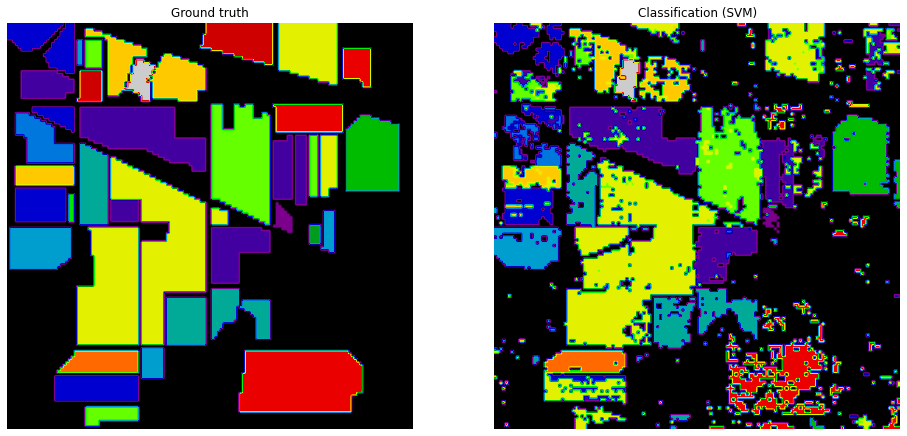

In [13]:
clmap = svm.predict(X).reshape(r, c)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Ground truth')
plt.imshow(gt, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(122)
plt.title('Classification (SVM)')
plt.imshow(clmap, cmap='nipy_spectral')
plt.axis('off')
plt.show()